**Question 1**

MDP Bellman Policy Equations

$$V^{\pi_D}(s) = R^{\pi_D}(s,\pi_D(s)) + \gamma \sum_{s' \in \mathcal{N}} P^{\pi_D}(s,\pi_D(s),s')V^{\pi_D}(s'))$$
$$V^{\pi_D}(s) = Q^{\pi_D}(s,\pi_D(s))$$
$$ Q^{\pi_D}(s,\pi_D(s)) = R^{\pi_D}(s,\pi_D(s)) + \gamma \sum_{s' \in \mathcal{N}} P^{\pi_D}(s,\pi_D(s),s',V^{\pi_D}(s'))$$
$$ Q^{\pi_D}(s,\pi_D(s)) = R^{\pi_D}(s,\pi_D(s)) + \gamma \sum_{s' \in \mathcal{N}} P^{\pi_D}(s,\pi_D(s),s')Q^{\pi_D}(s,\pi_D(s))$$



**Question 2**

Using Bellman optimality equation:

$$V^*(s) = \max_{a \in A}\{ R(s,a) + \gamma (P(s,a,s+1)V^*(s+1)+P(s,a,s)V^*(s)) \}$$

Note that that the action and reward are not dependent on the state. Therefore, $V^*(s)=V^*(s+1)$.

We know $R(s,a) = (1-a).a + (1+a).(1-a)$. And $P(s,a,s+1) = a$, $P(s,a,s)=1-a$. On substituting to the above, we get

$$V^*(s) = \frac{\max_{a \in A}\{(1-a).(1-2a)\}}{1-\gamma}$$.

On solving we get $a^* = \frac{1}{4}$ and $V^*(s) = \frac{9}{4}.$

$\therefore \pi^*_D (s) = \frac{1}{4}$

**Question 4**

The optimal value funciton will be

$$V^*(s) = max_{a\in R}\{-P(s,a,s').e^{a.s'}\}$$
$$V^*(s) =  max_{a\in R}\{ -\int_{-\infty}^{\infty} \frac{1}{\sqrt{2}\pi\sigma}e^{-\frac{(x-s)^2}{2\sigma^2}} e^{a.x}dx\}$$

We complete the squares $(x-(s+a\sigma^2))^2$ to get the expectation of a gaussian distribution that is equal to 1. We then have remaining

$$V^*(s) =  max_{a\in R}\{ -e^{sa + \frac{a^2\sigma^2}{2}} \}$$.

We can find $a^*$ by taking the partial derivative of the above with $a$ and equating with zero.

$$a^* = -\frac{s}{\sigma^2}$$

We can also easily check that the second derivative at $a^*$ is negative. Thus $a^*$ maximizes the value function. Therefore, we get

$$V^*(s) = -e^{-\frac{s^2}{2\sigma^2}}$$

**Question 3**

[0.57142857 0.71428571]
For State FrogState(leaf=2): Do Action 0
For State FrogState(leaf=1): Do Action 1

[0.65957447 0.70212766 0.72340426 0.74468085 0.78723404]
For State FrogState(leaf=5): Do Action 0
For State FrogState(leaf=4): Do Action 0
For State FrogState(leaf=3): Do Action 0
For State FrogState(leaf=2): Do Action 0
For State FrogState(leaf=1): Do Action 1

[0.67567568 0.70523649 0.71368243 0.71790541 0.72128378 0.72550676
 0.7339527  0.76351351]
For State FrogState(leaf=8): Do Action 0
For State FrogState(leaf=7): Do Action 0
For State FrogState(leaf=6): Do Action 0
For State FrogState(leaf=5): Do Action 0
For State FrogState(leaf=4): Do Action 0
For State FrogState(leaf=3): Do Action 0
For State FrogState(leaf=2): Do Action 0
For State FrogState(leaf=1): Do Action 1



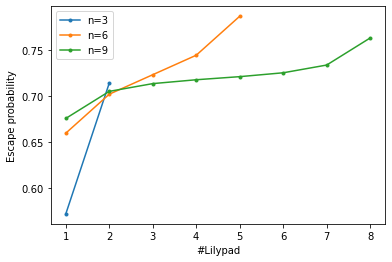

In [12]:
from dataclasses import dataclass
import sys
sys.path.append("../")
from rl.chapter3.simple_inventory_mdp_cap import InvOrderMapping
from typing import Tuple, Dict, Mapping
from rl.markov_decision_process import FiniteMarkovDecisionProcess
from rl.policy import FiniteDeterministicPolicy
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess
from rl.distribution import Categorical, Constant, Uniform
from copy import deepcopy

@dataclass(frozen=True)
class FrogState:
    leaf: int


InvOrderMapping = Mapping[
    FrogState,
    Mapping[int, Categorical[Tuple[FrogState, int]]]
]


class FrogLilypad(FiniteMarkovDecisionProcess[FrogState, int]):
    def __init__(self, n: int):
        self.n: int = n
        self.rmap = {0: 0, n: 1}
        super().__init__(self.get_action_transition_reward_map())

    def get_action_transition_reward_map(self) -> InvOrderMapping:
        d: Dict[FrogState, Dict[int, Categorical[Tuple[FrogState, int]]]] = {}
        def r(j): return self.rmap[j] if j in self.rmap else 0

        for i in range(1, self.n):
            act_dict = {}
            for a in [0, 1]:
                if not a:
                    a0 = {(FrogState(i-1), r(i-1)): i/self.n,
                          (FrogState(i+1), r(i+1)): (self.n-i)/self.n}
                    act_dict[a] = Categorical(a0)
                else:
                    act_dict[a] = Categorical(
                        {(FrogState(x), r(x)): 1/self.n for x in range(0, self.n+1) if x != i})
            d[FrogState(i)] = deepcopy(act_dict)
        return d


if __name__ == "__main__":
    x = []
    y = []
    l = [3,6,9]
    for leaves in l: 
        val_fun_max = [-1000 for x in range(0, leaves-1)]
        fl: FiniteMarkovDecisionProcess[FrogState, int] = FrogLilypad(n=leaves)
        for i in range(0, 2**(leaves-1)):
            k = i
            j = leaves-1
            sample_p = {}
            while j > 0:
                r = k % 2
                sample_p[FrogState(j)] = r
                k = int(k/2)
                j = j-1

            fdp: FiniteDeterministicPolicy[FrogState,
                                           int] = FiniteDeterministicPolicy(sample_p)

            implied_mrp: FiniteMarkovRewardProcess[FrogState] = fl.apply_finite_policy(
                fdp)
            val_fun = implied_mrp.get_value_function_vec(gamma=1)
            # print(val_fun)
            if (val_fun > val_fun_max).all():
                val_fun_max = val_fun
                best_pol = fdp
                best_mrp = implied_mrp

        print(val_fun_max)
        print(best_pol)
        x.append(list(range(1,leaves)))
        y.append(val_fun_max)
        
    from matplotlib import pyplot as plt
    plt.plot(x[0],y[0], ".-", label='n=3')
    plt.plot(x[1],y[1], ".-", label='n=6')
    plt.plot(x[2],y[2], ".-", label='n=9')
    plt.xlabel("#Lilypad")
    plt.ylabel('Escape probability')
    plt.legend()
    plt.show()

    

**The optimal policy is to take action B when on the first lilypad and action A on all other lilypads.**